### 数据分析

1. 整体统计数据特征，包括 query 数量，每条 query 对应的候选 doc 的平均数量， 所有 doc 的长度分布
2. 在 query 粒度上去重，将一样 query 多条数据，多个 doc 合并，对每个 query 下的所有 doc 进行去重

In [36]:
import warnings
warnings.filterwarnings("ignore")
import json
file_path = "/Users/codeaspoetry/Desktop/ths/query_docs_3k.jsonl"
query_len_list = []
repeat_content_num = 0
query_docs_dict = {}

yuanshi_doc_num = 0

with open(file_path, "r", encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        sample = json.loads(line)
        yuanshi_doc_num += len(sample['docs'])
        if sample['query'] not in query_docs_dict.keys():
            temp_list_3 = []
            for item in sample['docs']:
                if item not in temp_list_3:
                    temp_list_3.append(item)
                else:
                    repeat_content_num +=1
            query_docs_dict[sample['query']] = temp_list_3
        else:
            temp_list_1 = query_docs_dict[sample['query']]
            temp_list_2 = sample['docs']
            temp_list_3 = []
            
            for item in temp_list_1:
                if item not in temp_list_3:
                    temp_list_3.append(item)
                else:
                    repeat_content_num +=1
                    
            for item in temp_list_2:
                if item not in temp_list_3:
                    temp_list_3.append(item)
                else:
                    repeat_content_num +=1
                     
            query_docs_dict[sample['query']] = temp_list_3

print(len(query_docs_dict))  # 2991

for key_ in query_docs_dict.keys():
    query_len_list.append((len(key_), key_))
    docs = query_docs_dict[key_]
    for i in range(len(docs)):
        doc_ = docs[i]
        total_doc_num += 1
        if doc_['label'] == 3:
            doc_3_point_num += 1
        if doc_['label'] == 1:
            doc_1_point_num += 1 
      
print(repeat_content_num)   # 120
print(yuanshi_doc_num)

2991
120
23530


In [13]:
# 2991 个 query
docs_num_per_query_list = []
for item in query_docs_dict.keys():
    docs = query_docs_dict[item]
    docs_num_per_query_list.append(len(docs))

print(len(docs_num_per_query_list))
print(max(docs_num_per_query_list), min(docs_num_per_query_list), sum(docs_num_per_query_list)/len(docs_num_per_query_list))

2991
16 6 7.826813774657305


In [14]:
# 根据 query_docs_dict 获取所有的 doc ，并进行整体去重
docs_list = []
for item in query_docs_dict.keys():
    docs = query_docs_dict[item]
    for doc in docs:
        content = doc['content']
        docs_list.append(content)

len(docs_list), len(list(set(docs_list)))

(23410, 19582)

In [48]:
# 获取文档长度分布
from collections import Counter
docs_list = list(set(docs_list))
doc_len_list = [len(item) for item in docs_list]
print(min(doc_len_list), max(doc_len_list), sum(doc_len_list)/len(doc_len_list), len(doc_len_list))
new_dict = Counter(doc_len_list)
temp_list = [(k,new_dict[k]) for k in sorted(new_dict.keys())]
qujian_list = [(2**i, 2**(i+1)) for i in range(1,13)]
num_list = [0 for i in range(len(qujian_list))]

for item in temp_list:
    for t in range(len(qujian_list)):
        if item[0]>= qujian_list[t][0] and item[0] < qujian_list[t][1]:
            num_list[t] += item[1]
            break
print(qujian_list)
print(num_list)


24 4293 454.2592687161679 19582
[(2, 4), (4, 8), (8, 16), (16, 32), (32, 64), (64, 128), (128, 256), (256, 512), (512, 1024), (1024, 2048), (2048, 4096), (4096, 8192)]
[0, 0, 0, 3, 23, 315, 1290, 16532, 1384, 20, 14, 1]


In [41]:
# bert 最大支持 512 , 单条 doc 本身最大能覆盖约 92.74%，如果考虑特殊token，考虑 query，考虑对比学习多条样本，BERT最大长度是不够的
sum([3, 23, 315, 1290, 16532])/sum(num_list)

0.9275354917781636

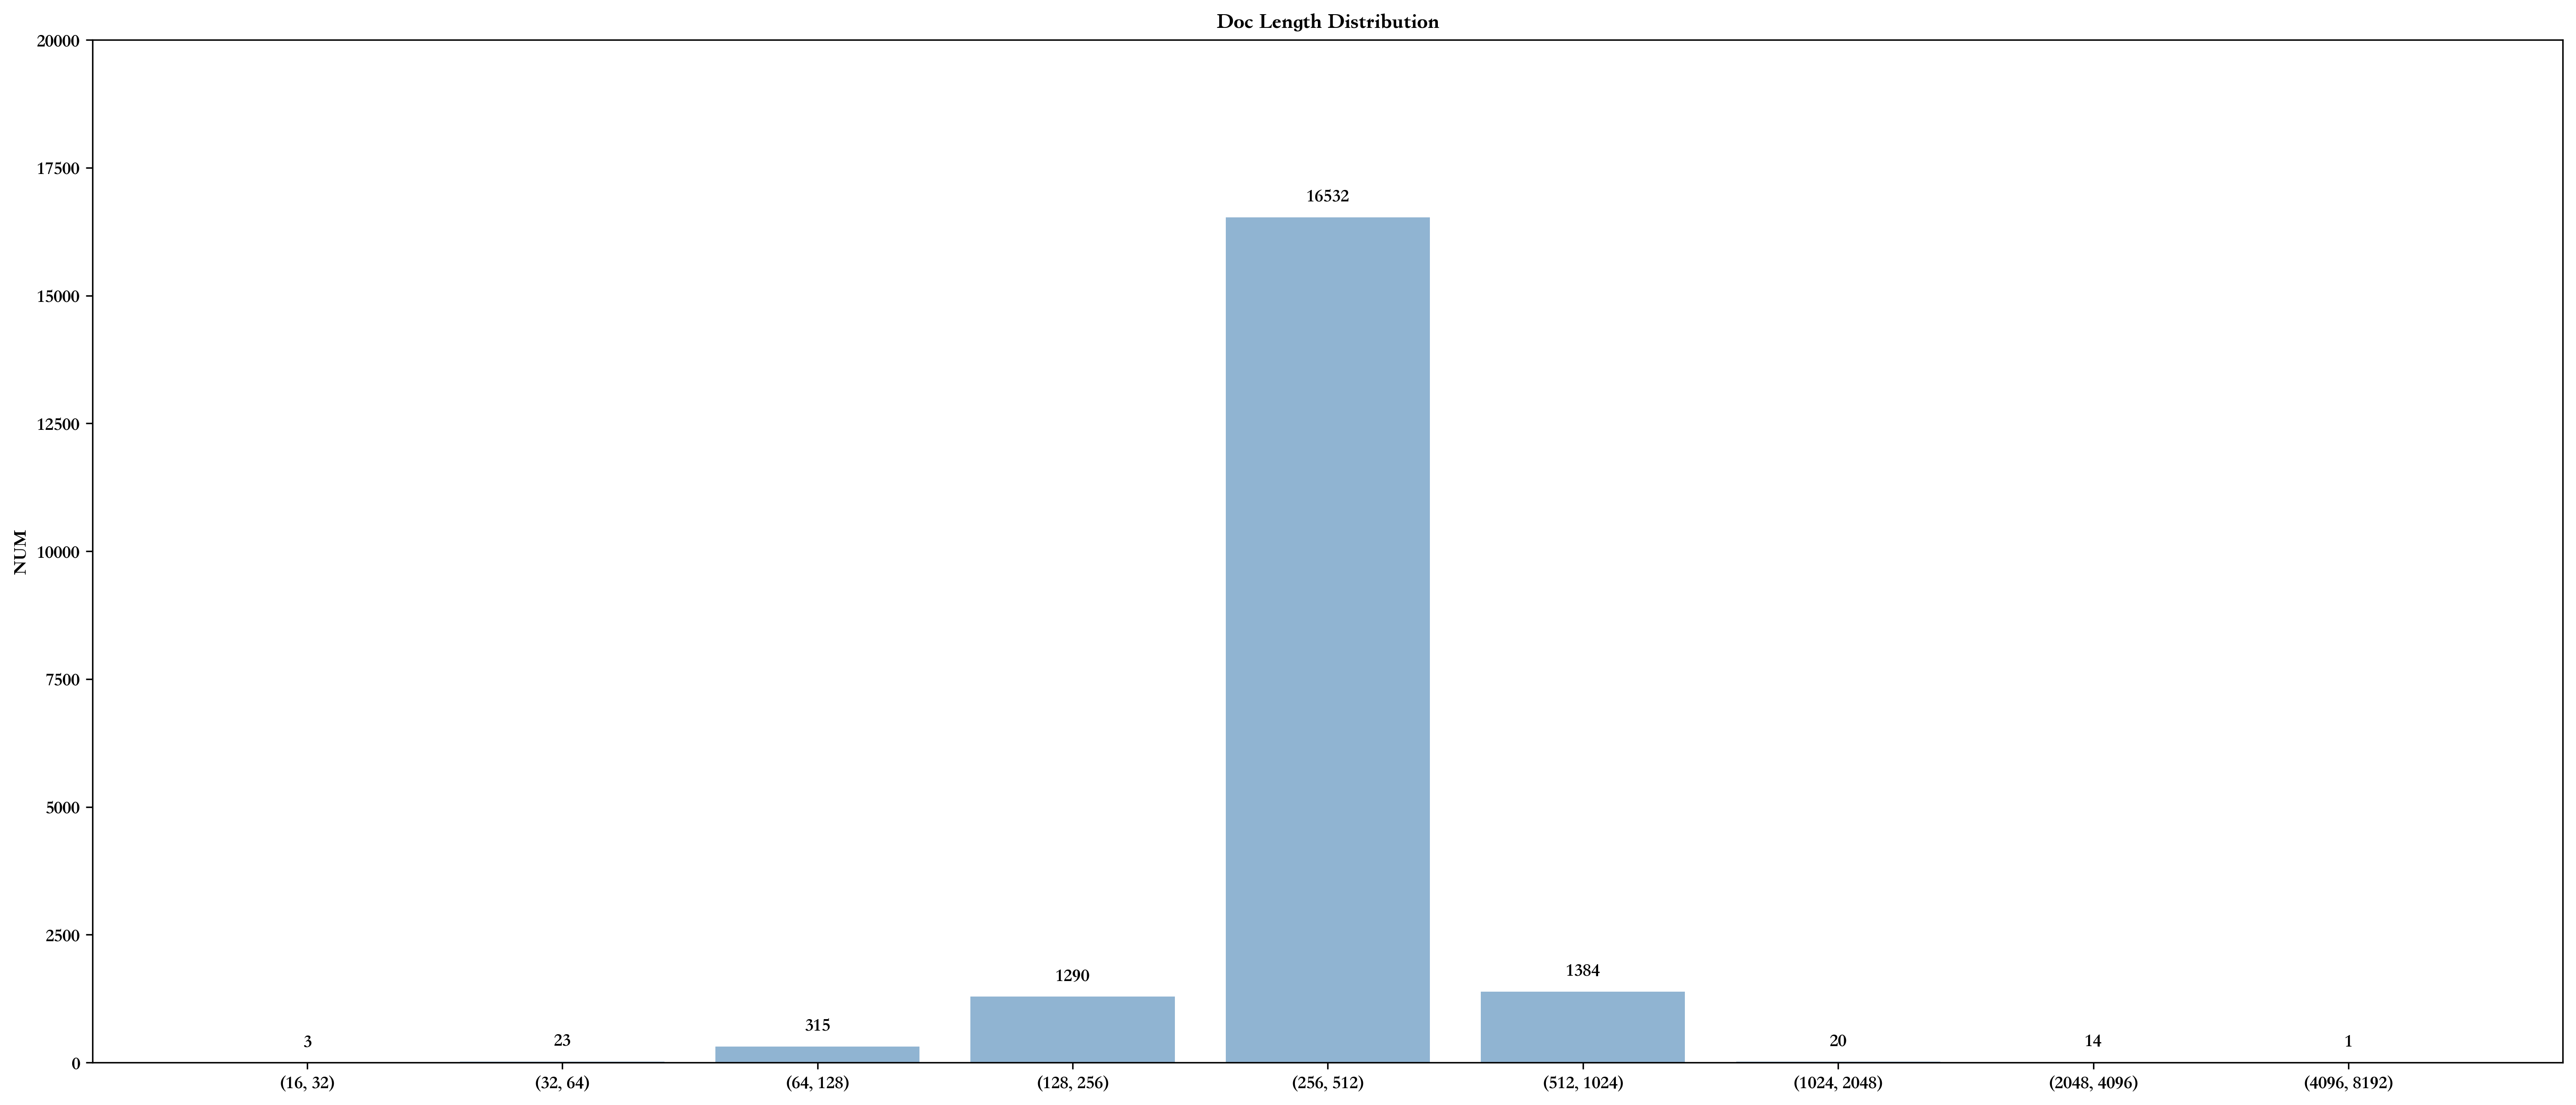

In [44]:
# 画出doc长度分布条形图
# 导入模块
import matplotlib.pyplot as plt
plt.figure(dpi=300,figsize=(24,10))
# 构建数据
plt.rcParams['font.sans-serif']=['Songti SC'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
NUM = [3, 23, 315, 1290, 16532, 1384, 20, 14, 1]
# 绘图
plt.bar(range(9),NUM,align = "center",color = "steelblue",alpha = 0.6)

# 添加y轴标签
plt.ylabel("NUM")
# 设置Y轴的刻度范围
plt.ylim([0,20000])

# 添加x轴刻度标签
plt.xticks(range(9),[(16, 32), (32, 64), (64, 128), (128, 256), (256, 512), (512, 1024), (1024, 2048), (2048, 4096), (4096, 8192)])

# 添加标题
plt.title('Doc Length Distribution')

# 为每个条形图添加数值标签
for x,y in enumerate(NUM):
    plt.text(x,y+300,'%s' %round(y,1),ha='center')# y+300 标签的坐标


# 显示图形
plt.show()   

## 切分数据集
1. held in 测试集，100 条 query 来自训练集，各取一条1分doc和3分doc，取出来的doc从训练集中去除
2. held out 测试集，100 条 query ，完全独立训练集，100条 query 对应的 doc 全部拿来，但如果 doc 还是作为训练集其他 query 的候选 doc ，则在训练集中予以保留
3. 除上之外，剩余的是训练集   

In [223]:
len(query_docs_dict)

2991

In [224]:
total_samples = []

for key_ in query_docs_dict.keys():
    docs = query_docs_dict[key_]
    total_samples.append({
        "query": key_,
        "docs": docs
    })
len(total_samples)

2991

In [225]:
from random import sample
held_out_eval = sample(total_samples, 100)

rest_data = []

for item in total_samples:
    if item not in held_out_eval:
        rest_data.append(item)

len(rest_data), len(held_out_eval)

(2891, 100)

In [226]:
train_dev_data_part = []
held_in_eval = []

need_alter = sample(rest_data, 100)

for item in need_alter:
    
    docs = item['docs']
    docs = sample(docs, len(docs))
    query = item['query']
    
    held_in_docs_1_point = []
    held_in_docs_3_point = []
    train_dev_docs = []
    
    for i in range(len(docs)):
        
        if docs[i]['label'] == 1 and len(held_in_docs_1_point) < 1:
            held_in_docs_1_point.append(docs[i])
        elif docs[i]['label'] == 3 and len(held_in_docs_3_point) < 1:
            held_in_docs_3_point.append(docs[i])
        else:
            train_dev_docs.append(docs[i])
    
    assert(len(docs) == len(train_dev_docs)+2)
    
    held_in_eval.append({
        "query": query,
        "docs": held_in_docs_1_point + held_in_docs_3_point
    })
    
    train_dev_data_part.append({
        "query": query,
        "docs": train_dev_docs
    })

In [227]:
len(train_dev_data_part)

100

In [228]:
train_dev_data_part_query = [item["query"] for item in train_dev_data_part]

train_dev_data = []

for item in rest_data:
    if item['query'] not in train_dev_data_part_query:
        train_dev_data.append(item)

train_dev_data = train_dev_data + train_dev_data_part

len(train_dev_data)

2891

In [229]:
len(held_in_eval)

100

In [230]:
print(len(train_dev_data))
print(len(held_out_eval))
print(len(held_in_eval))

2891
100
100


### 将三块merge，进行比对，验证切分得对不对

In [231]:
houyan_samples = {}
queries_list = []

len(queries_list)

for i in range(len(train_dev_data)):
    if train_dev_data[i]['query'] not in queries_list:
        queries_list.append(train_dev_data[i]['query'])
        houyan_samples[train_dev_data[i]['query']] = train_dev_data[i]['docs']
    else:
        temp_list_1 = houyan_samples[train_dev_data[i]['query']]
        for item in train_dev_data[i]['docs']:
            if item not in temp_list_1:
                temp_list_1.append(item)
        houyan_samples[train_dev_data[i]['query']] = temp_list_1
        
for i in range(len(held_out_eval)):
    if held_out_eval[i]['query'] not in queries_list:
        queries_list.append(held_out_eval[i]['query'])
        houyan_samples[held_out_eval[i]['query']] = held_out_eval[i]['docs']
    else:
        temp_list_1 = houyan_samples[held_out_eval[i]['query']]
        for item in held_out_eval[i]['docs']:
            if item not in temp_list_1:
                temp_list_1.append(item)
        houyan_samples[held_out_eval[i]['query']] = temp_list_1

for i in range(len(held_in_eval)):
    if held_in_eval[i]['query'] not in queries_list:
        queries_list.append(held_in_eval[i]['query'])
        houyan_samples[held_in_eval[i]['query']] = held_in_eval[i]['docs']
    else:
        temp_list_1 = houyan_samples[held_in_eval[i]['query']]
        for item in held_in_eval[i]['docs']:
            if item not in temp_list_1:
                temp_list_1.append(item)
        houyan_samples[held_in_eval[i]['query']] = temp_list_1

In [232]:
len(houyan_samples)

2991

In [234]:
total_doc_num = 0
doc_3_point_num = 0
doc_1_point_num = 0
doc_len_list = []
query_len_list = []

repeat_content_num = 0

for key_ in houyan_samples.keys():
    query_len_list.append((len(key_), key_))
    docs = houyan_samples[key_]
    for i in range(len(docs)):
        doc_ = docs[i]
        doc_len_list.append(len(doc_['content']))

        total_doc_num += 1
        if doc_['label'] == 3:
            doc_3_point_num += 1
        if doc_['label'] == 1:
            doc_1_point_num += 1 
    
print(total_doc_num)        # 23410    
print(doc_3_point_num)      # 8412
print(doc_1_point_num)      # 14998    
print(repeat_content_num)   # 0

len(doc_len_list), len(query_len_list)

23410
8412
14998
0


(23410, 2991)

### 将切分好的训练集、held in测试集，held out 测试集文件化

In [363]:
with open("/Users/codeaspoetry/Desktop/train_dev_data.jsonl", "w", encoding="utf-8") as fw:
    for item in train_dev_data:
        fw.write(json.dumps(item, ensure_ascii=False))
        fw.write("\n")

In [240]:
held_out_eval[0]

{'query': '永州江永',
 'docs': [{'id': 'id_29064',
   'label': 3,
   'content': '红网时刻新闻5月29日讯（通讯员 何冰 汪祚斌）5月29日，永州市第一届专业森林消防队伍技能比武（南部赛区）大赛在宁远县高新园区圆满落幕，经过紧张激烈角逐，江永县代表队斩获第一名。 此次竞赛内容包括以水灭火作战、无人机侦查和人员急救和高压水炮操作。比赛现场，江永县参赛选手们展现出了良好的精神风貌和娴熟的技能战术配合水平，大家顽强拼搏，奋勇争先，把赛场当战场、把竞技当战斗，比出了水平、赛出了风格，展示了江永县专业森林消防队伍的风采和整体素质，检验了快速反应和应急作战能力。 通过参加此次活动，对进一步提高江永县专业森林消防队伍业务能力，树立队伍形象，具有积极的推动作用。江永县应急管理局党委书记、局长黄野表示，下一步将继续加强常态化的训练、演练，切实将江永县专业森林消防队伍锤炼成召之即来、来之能战、战之能胜的精兵强将；进一步加大森林消防宣传教育力度，提高群众的森林防火意识，营造全民防火的浓厚氛围，坚决筑牢森林防火安全网。 举报/反馈'},
  {'id': 'id_29065',
   'label': 3,
   'content': '您好，欢迎来到万邦物流平台! 请登录 | 立即注册 微信公众号 微信小程序 APP下载 物信通服务 物流商家入驻 全国站 [切换城市] 查物流 | 查公司 | 查园区 | 国际物流 物流专线咨询电话 400-086-9156 首页 物流专线 物流公司 物流园区 国际物流 落地分流 资讯中心 物流配套 物流圈子 城市： 浙江 广东 山东 上海 河北 湖北 四川 北京 天津 江西 福建 辽宁 江苏 重庆 陕西 安徽 湖南 河南 山西 云南 贵州 甘肃 黑龙江 新疆 广西 吉林 宁夏 内蒙古 青海 西藏 海南 香港 您所在的位置： 万邦物流平台 > 全国公路里程查询 > 永州到全国路线 > 从永州到江永多少公里？ 热搜线路： 永州到湖南永州路线查询 永州到广东东莞路线查询 永州到广东中山路线查询 永州到广东潮州路线查询 永州到广东潮州潮安区路线查询 永州到广东深圳宝安区路线查询 永州到广东深圳路线查询 永州到广东东莞横沥镇路线查询 永州到广东东莞寮步镇路线查询 永州到广东中山古镇镇路线查询 

In [250]:
held_in_eval[0]

{'query': '"""贵金属交易 私下"""',
 'docs': [{'id': 'id_2868',
   'label': 1,
   'content': '基金简称南方崇元纯债债券型证券投资基金A类基金全称南方崇元纯债债券A基金类型债券型基金代码010353成立日期2021-03-31 00:00:00成立规模192,482,224元基金管理人南方基金管理股份有限公司基金托管人中国邮政储蓄银行股份有限公司 投资理念 本基金将重点投资信用类债券，以提高组合收益能力。 收益率曲线形状变化代表长、中、短期债券收益率差异变化，相同久期债券组合在收益率曲线发生变化时差异较大。 放大操作即以组合现有债券为基础，利用买断式回购、质押式回购等方式融入低成本资金，并购买剩余年限相对较长并具有较高收益的债券，以期获取超额收益的操作方式。 资产支持证券投资关键在于对基础资产质量及未来现金流的分析，本基金将在国内资产证券化产品具体政策框架下，采用基本面分析和数量化模型相结合，对个券进行风险分析和价值评估后进行投资。 本基金在进行国债期货投资时，将根据风险管理原则，以套期保值为主要目的，采用流动性好、交易活跃的期货合约，通过对债券市场和期货市场运行趋势的研究，结合国债期货的定价模型寻求其合理的估值水平，与现货资产进行匹配，'},
  {'id': 'id_12910',
   'label': 3,
   'content': '并处以吊销营业执照、责令停业。 （五）违反本条例第七条规定，将金银计价使用、私相买卖、借贷抵押的，由中国人民银行或者工商行政管理机关予以强制收购或者贬值收购。情节严重的，由工商行政管理机关处以罚款或者没收。 （六）违反本条例第五章有关金银进出国境管理规定或者用各种方法偷运金银出境的，由海关依据本条例和国家海关法规处理。 （七）违反本条例第十四条规定的，由中国人民银行予以收兑。对直接责任人员由有关单位追究行政责任。 第三十二条 违反本条例规定，已构成犯罪行为的，由司法机关依法追究刑事责任。 二、黄金买卖需要许可证吗 如果只是日用少量买卖黄金并不需要办理什么手续，一般来说我国法律没有明确的倒卖黄金罪，但是如果是走私黄金就构成走私贵金属罪，如果经营手续不全大量买卖黄金，就会构成非法经营罪。 三、走私贵重金属罪如何认定 走私贵重金属罪，是指走私国家禁止出口的

### prompt改造

In [248]:

template_prompt_1 = '''下面有一个来自用户的查询query和一个候选文档doc：
===
用户查询query：{}
候选文档doc：{}
===
请判断该文档doc能不能作为此查询query的相关内容返回给用户。建议从文本相关度进行判断，请直接给出答案，回答“能”还是“不能”，不要输出其他内容。'''

In [249]:
template_prompt_2 = '''下面有一个来自用户的查询query和两个候选文档doc1和doc2：
===
用户查询query：{}
候选文档一doc1：{}
候选文档二doc2：{}
===
请判断哪个候选文档更与此查询query相关，建议从文本相关度进行判断，请直接给出更相关的答案，回答“doc1”还是“doc2，不要输出其他内容”。'''

In [251]:
# with open("/Users/codeaspoetry/Desktop/held_out_eval.jsonl", "w", encoding="utf-8") as fw:
#     for item in held_out_eval:
#         new_sample = {}
#         query = item['query']
#         docs = item['docs']
#         new_docs = []
#         for i in range(len(docs)):
#             doc = docs[i]
#             prompt_1 = template_prompt_1.format(query, doc['content'])
#             doc['prompt_1'] = prompt_1
#             new_docs.append(doc)
#         new_sample['query'] = query
#         new_sample['docs'] = new_docs
#         fw.write(json.dumps(new_sample, ensure_ascii=False))
#         fw.write("\n")

# with open("/Users/codeaspoetry/Desktop/held_in_eval.jsonl", "w", encoding="utf-8") as fw:
#     for item in held_in_eval:
#         new_sample = {}
#         query = item['query']
#         docs = item['docs']
#         new_docs = []
#         for i in range(len(docs)):
#             doc = docs[i]
#             prompt_1 = template_prompt_1.format(query, doc['content'])
#             doc['prompt_1'] = prompt_1
#             new_docs.append(doc)
#         new_sample['query'] = query
#         new_sample['docs'] = new_docs
        
        
#         temp_docs = sample(docs, len(docs))
#         label = ""
#         for i in range(len(temp_docs)):
#             if temp_docs[i]['label'] == 3:
#                 label = temp_docs[i]['content']
        
#         doc_dict = {
#             'doc1': temp_docs[0]['content'],
#             'doc2': temp_docs[1]['content'],
#             'label': label
#         }
#         prompt_2 = template_prompt_2.format(query, doc_dict['doc1'], doc_dict['doc2'])
        
#         new_sample['doc_dict'] = doc_dict
#         new_sample['prompt_2'] = prompt_2
#         fw.write(json.dumps(new_sample, ensure_ascii=False))
#         fw.write("\n")

In [252]:
with open("/Users/codeaspoetry/Desktop/held_in_eval_output.jsonl", "r", encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        line = line.strip()
        sample = json.loads(line)
        print(sample)
        break

{'query': '"""贵金属交易 私下"""', 'docs': [{'id': 'id_2868', 'label': 1, 'content': '基金简称南方崇元纯债债券型证券投资基金A类基金全称南方崇元纯债债券A基金类型债券型基金代码010353成立日期2021-03-31 00:00:00成立规模192,482,224元基金管理人南方基金管理股份有限公司基金托管人中国邮政储蓄银行股份有限公司 投资理念 本基金将重点投资信用类债券，以提高组合收益能力。 收益率曲线形状变化代表长、中、短期债券收益率差异变化，相同久期债券组合在收益率曲线发生变化时差异较大。 放大操作即以组合现有债券为基础，利用买断式回购、质押式回购等方式融入低成本资金，并购买剩余年限相对较长并具有较高收益的债券，以期获取超额收益的操作方式。 资产支持证券投资关键在于对基础资产质量及未来现金流的分析，本基金将在国内资产证券化产品具体政策框架下，采用基本面分析和数量化模型相结合，对个券进行风险分析和价值评估后进行投资。 本基金在进行国债期货投资时，将根据风险管理原则，以套期保值为主要目的，采用流动性好、交易活跃的期货合约，通过对债券市场和期货市场运行趋势的研究，结合国债期货的定价模型寻求其合理的估值水平，与现货资产进行匹配，', 'prompt_1': '下面有一个来自用户的查询query和一个候选文档doc：\n===\n用户查询query："""贵金属交易 私下"""\n候选文档doc：基金简称南方崇元纯债债券型证券投资基金A类基金全称南方崇元纯债债券A基金类型债券型基金代码010353成立日期2021-03-31 00:00:00成立规模192,482,224元基金管理人南方基金管理股份有限公司基金托管人中国邮政储蓄银行股份有限公司 投资理念 本基金将重点投资信用类债券，以提高组合收益能力。 收益率曲线形状变化代表长、中、短期债券收益率差异变化，相同久期债券组合在收益率曲线发生变化时差异较大。 放大操作即以组合现有债券为基础，利用买断式回购、质押式回购等方式融入低成本资金，并购买剩余年限相对较长并具有较高收益的债券，以期获取超额收益的操作方式。 资产支持证券投资关键在于对基础资产质量及未来现金流的分析，本基金将在国内资产证券化产品具体政策框架下，采用基本面分析和数量化模型相结合，对个券

### 统计 Qwen-72b-Chat 指标性能

In [270]:
query_total_num = 0
metric_per_query = {}
query_doc_pair_num = 0
per_num_total_docs = 0
rec_num_total_docs = 0


with open("/Users/codeaspoetry/Desktop/held_out_eval_output.jsonl", "r", encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        line = line.strip()
        sample = json.loads(line)
        
        query = sample['query']
        new_docs = sample['new_docs']
        pos_count_num = 0
        true_count_num = 0
        pred_pos_count_num = 0
        docs_num = len(new_docs)
        
        for i in range(len(new_docs)):
            doc = new_docs[i]
            if doc['label'] == 3:
                true_count_num += 1
            if doc['prompt_1_output'] == "能":
                pred_pos_count_num += 1
            if doc['label'] == 3 and doc['prompt_1_output'] == "能":
                pos_count_num += 1
        
        metric_per_query[query] = {
            'docs_num': docs_num,
            'true_count_num': true_count_num,
            'pred_pos_count_num': pred_pos_count_num,
            'pos_count_num': pos_count_num,
        }
                
metric_per_query

{'永州江永': {'docs_num': 8,
  'true_count_num': 3,
  'pred_pos_count_num': 3,
  'pos_count_num': 3},
 '2023年1月03日到2023年12月29区间板块涨跌幅': {'docs_num': 8,
  'true_count_num': 3,
  'pred_pos_count_num': 1,
  'pos_count_num': 1},
 '中国人寿的员工人数': {'docs_num': 8,
  'true_count_num': 3,
  'pred_pos_count_num': 2,
  'pos_count_num': 2},
 '长线': {'docs_num': 8,
  'true_count_num': 3,
  'pred_pos_count_num': 3,
  'pos_count_num': 3},
 '300174重仓怎么操作': {'docs_num': 8,
  'true_count_num': 3,
  'pred_pos_count_num': 2,
  'pos_count_num': 2},
 '002011业绩预告类型，': {'docs_num': 8,
  'true_count_num': 3,
  'pred_pos_count_num': 3,
  'pos_count_num': 3},
 '鲁抗生产地赛尼松吗': {'docs_num': 8,
  'true_count_num': 3,
  'pred_pos_count_num': 1,
  'pos_count_num': 1},
 '603166主力盈亏情况': {'docs_num': 7,
  'true_count_num': 2,
  'pred_pos_count_num': 2,
  'pos_count_num': 2},
 '002626.SZ 利好股票': {'docs_num': 7,
  'true_count_num': 2,
  'pred_pos_count_num': 3,
  'pos_count_num': 2},
 'st大集是否符合退市规定': {'docs_num': 8,
  'true_count_num'

In [276]:
p_per_query = []
r_per_query = []
for item in metric_per_query.keys():
    
    if metric_per_query[item]['pred_pos_count_num'] == 0:
        if metric_per_query[item]['pos_count_num'] == 0:
            p_per_query.append(1.0)
        else:
            p_per_query.append(0.0)
    else:
        p_per_query.append(metric_per_query[item]['pos_count_num']/metric_per_query[item]['pred_pos_count_num'])
    
    if metric_per_query[item]['true_count_num'] == 0:
        if metric_per_query[item]['pos_count_num'] == 0:
            p_per_query.append(1.0)
        else:
            p_per_query.append(1.0)
    else:
        r_per_query.append(metric_per_query[item]['pos_count_num']/metric_per_query[item]['true_count_num'])
    
print(max(p_per_query), min(p_per_query), len(p_per_query))
print(max(r_per_query), min(r_per_query), len(r_per_query))
sum(p_per_query)/100, sum(r_per_query)/100

1.0 0.6 100
1.0 0.0 100


(0.9901666666666666, 0.7433333333333332)

In [278]:
query_total_num = 0
metric_per_query = {}
pair_query = 0
query_doc_pair_num = 0
per_num_total_docs = 0
rec_num_total_docs = 0
doc1_num = 0
doc2_num = 0


with open("/Users/codeaspoetry/Desktop/held_in_eval_output.jsonl", "r", encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        line = line.strip()
        sample = json.loads(line)
        
        query = sample['query']
        new_docs = sample['new_docs']
        pos_count_num = 0
        true_count_num = 0
        pred_pos_count_num = 0
        docs_num = len(new_docs)
        
        for i in range(len(new_docs)):
            doc = new_docs[i]
            if doc['label'] == 3:
                true_count_num += 1
            if doc['prompt_1_output'] == "能":
                pred_pos_count_num += 1
            if doc['label'] == 3 and doc['prompt_1_output'] == "能":
                pos_count_num += 1
        
        metric_per_query[query] = {
            'docs_num': docs_num,
            'true_count_num': true_count_num,
            'pred_pos_count_num': pred_pos_count_num,
            'pos_count_num': pos_count_num,
        }
        
#         print(sample['doc_dict'])
#         print(sample['prompt_2_output'])
#         break
        if sample['doc_dict'][sample['prompt_2_output']] == sample['doc_dict']['label']:
            pair_query += 1
        else:
            print("exe")
        
        if sample['prompt_2_output'] == "doc1":
            doc1_num += 1
        if sample['prompt_2_output'] == "doc2":
            doc2_num += 1

print(pair_query)

p_per_query = []
r_per_query = []
for item in metric_per_query.keys():
    
    if metric_per_query[item]['pred_pos_count_num'] == 0:
        if metric_per_query[item]['pos_count_num'] == 0:
            p_per_query.append(1.0)
        else:
            p_per_query.append(0.0)
    else:
        p_per_query.append(metric_per_query[item]['pos_count_num']/metric_per_query[item]['pred_pos_count_num'])
    
    if metric_per_query[item]['true_count_num'] == 0:
        if metric_per_query[item]['pos_count_num'] == 0:
            p_per_query.append(1.0)
        else:
            p_per_query.append(1.0)
    else:
        r_per_query.append(metric_per_query[item]['pos_count_num']/metric_per_query[item]['true_count_num'])
    
print(max(p_per_query), min(p_per_query), len(p_per_query))
print(max(r_per_query), min(r_per_query), len(r_per_query))
print(doc1_num, doc2_num)
sum(p_per_query)/100, sum(r_per_query)/100

100
1.0 0.5 100
1.0 0.0 100
45 55


(0.995, 0.79)

### 根据 query_docs_dict 建立需要获取向量的 queies_list 和 docs_list，并建立索引

In [301]:
query_docs_dict

{'91.62亿收购河北保变电气全部股权的新闻': [{'id': 'id_15577',
   'label': 3,
   'content': '思绪的天空2023 保变电气成功摘牌获得河北建设投资集团持有的秦变公司8.21%股权 近日，保变电气宣布通过与河北建设投资集团签署协议的方式，成功获得了后者所持有的秦变公司8.21%的股权。这一交易金额达到了8940.59万元人民币。在收购完成后，秦变公司将正式成为保变电气的全资子公司。据悉，这笔交易已经得到了中国兵器装备集团的批准，不需要提交股东大会审议。 目前，秦变公司的股份分布如下：保变电气持有91.79%，河北省建设投资集团有限责任公司（简称“省建投”）持有8.21%。值得注意的是，省建投与保变电气之间并无关联关系，因此这次交易并不构成关联交易或重大资产重组。 经过评估，秦变公司8.21%的股权评估价值为6940.59万元人民币。该笔股权转让的挂牌起始时间为2023年11月8日，截止日为2023年12月5日。 此次股权收购对于保变电气来说，符合其整体战略规划，有助于加强对秦变公司的生产运营管控以及提升品牌价值。对公司长期发展将产生积极的推动作用。 御宅族都在用的AI动漫头像生成神器，点击这里，上传照片免费生成 >>'},
  {'id': 'id_5027',
   'label': 3,
   'content': '交易不属于关联交易，未构成重大资产重组，本议案无需提交公司股东大会审议（详见2023年11月17日披露于上海证券交易所网站//www.sse.com.cn和《证券日报》上的相关公告）。 二、竞拍结果 截至2023年12月5日挂牌结束，本公司作为唯一竞标方被确认为标的产权的受让方，转让价格为人民币6940.59万元。交易双方于近日签署了《天威保变（秦皇岛）变压器有限公司股权转让协议》，本公司已全额支付转让价款。 三、交易合同的主要内容 （一）交易双方 1、转让方（甲方）：河北建设投资集团有限责任公司。 2、受让方（乙方）：保定天威保变电气股份有限公司。 （二）转让标的：天威保变（秦皇岛）变压器有限公司8.21%股权。 （三）转让价格：人民币6940.59万元。 （四）转让价款的支付 乙方在《股权转让协议》签订之日起5个工作日内将股权交易价款一次性全额支付至河北产权市场有限公司指定的结算账户。 （

In [303]:
queies_list = list(query_docs_dict.keys())
docs_list = []
for item in query_docs_dict.keys():
    docs = query_docs_dict[item]
    for doc in docs:
        content = doc['content']
        docs_list.append(content)

len(queies_list), len(docs_list)

(2991, 23410)

In [304]:
len(list(set(queies_list))), len(list(set(docs_list)))

(2991, 19582)

In [305]:
need_embed_queies_list = list(set(queies_list))
need_embed_docs_list = list(set(docs_list))

In [309]:
# with open("/Users/codeaspoetry/Desktop/queies_list.json", "w", encoding="utf-8") as fw_1:
#     for item in need_embed_queies_list:
#         fw_1.write(json.dumps({"query": item}, ensure_ascii=False))
#         fw_1.write("\n")

# with open("/Users/codeaspoetry/Desktop/docs_list.json", "w", encoding="utf-8") as fw_2:
#     for item in need_embed_docs_list:
#         fw_2.write(json.dumps({"doc": item}, ensure_ascii=False))
#         fw_2.write("\n")

In [311]:
len(need_embed_queies_list), need_embed_queies_list[-1]

(2991, '"""证券监督管理委员会 行政处罚"""')

In [310]:
len(need_embed_docs_list), need_embed_docs_list[-1]

(19582,
 '下有2个上市公司，分别是持股28.72%的棕榈股份和持股29.72%的GQY视讯。 一、荣科科技，超聚变借壳上市的唯一股票 1、豫信电子科技集团简介，有44个核心企业。具体如下附图。 2、豫信电子科技集团旗下唯一的上市公司是荣科科技。具体如下附图。 二、超聚变，原华为服务器业务 1、2021年9月15日，华为全资成立了超聚变数字技术有限公司，其主营业务是华为的X86服务器，受美国的制裁影响，退出了大股东身份，打包出售给了河南国资委旗下的豫信电子科技集团。具体如下附图。 2、超聚变数字技术有限公司是一家全球领先的算力基础设施与算力服务提供者。坚持"以客户为中心，以奋斗者为本，长期坚持艰苦奋斗，合作共赢"的核心价值观，持续为客户和伙伴创造价值，加速行业数字化转型。超聚变在全球设立了11个研究中心和7个地区部、5大供应中心，目前服务于全球130个国家和地区客户，包括全球211家财富500强企业，覆盖金融、运营商、互联网、交通能源等行业。 3、华为于2021年12月22日打包出售了超聚变，')

In [317]:
len(need_embed_queies_list), len(need_embed_docs_list)

(2991, 19582)

### 统计 gte-Qwen2-7B-instruct 性能指标

In [51]:
# 加载向量化后的 query 和 doc
import numpy as np

query_embedding_dir = "/Users/codeaspoetry/Desktop/ths/query_embeddings"
document_embedding_dir = "/Users/codeaspoetry/Desktop/ths/document_embeddings"

query_embedding_list = []

for i in range(94):
    temp_array = np.load(query_embedding_dir + "/" + "query_embeddings_{}.npy".format(str(i)))
    query_embedding_list.append(temp_array)

query_embedding = np.vstack(query_embedding_list)
query_embedding.shape

(2991, 3584)

In [52]:
query_embedding.shape

(2991, 3584)

In [53]:
# np.save("/Users/codeaspoetry/Desktop/ths/query_embeddings_2991.npy",query_embedding)

In [54]:
document_embedding_list = []
for i in range(2448):
    temp_array = np.load(document_embedding_dir + "/" + "document_embeddings_{}.npy".format(str(i)))
    document_embedding_list.append(temp_array)

document_embedding = np.vstack(document_embedding_list)
document_embedding.shape

(19582, 3584)

In [55]:
# np.save("/Users/codeaspoetry/Desktop/ths/document_embeddings_19582.npy",document_embedding)

In [327]:
scores = (query_embedding @ document_embedding.T) * 100
scores.shape

(2991, 19582)

In [328]:
len(held_in_eval), len(held_out_eval)

(100, 100)

In [332]:
import numpy as np

def top_K_idx(data, k):
    data = np.array(data)
    idx = data.argsort()[-k:][::-1]
    return idx

k = 3
s = [1,3,4,2,5]
top_K_idx(s, k)

array([4, 2, 1])

In [357]:
# 对 held_out_eval 进行逐 query 统计 recall@20
target_rec_at_20_list = []
for i in range(len(held_out_eval)):
    query = held_out_eval[i]['query']
    docs = held_out_eval[i]['docs']
    # 遍历 docs ，统计一共有多少需要召回
    query_pos_doc_num = 0
    target_docs_index = []
    for doc in docs:
        if doc['label'] == 3:
            query_pos_doc_num += 1
            target_docs_index.append(need_embed_docs_list.index(doc['content']))
    
    assert(len(target_docs_index)==query_pos_doc_num)
    
    qid = need_embed_queies_list.index(query)
    array_ = scores[qid]
    recall_20_array = top_K_idx(array_, 20)
    recall_20_docs = recall_20_array.tolist()
    
#     print(query)
#     print(query_pos_doc_num)
#     print(len(set(target_docs_index)&set(recall_20_docs)))
#     print(recall_20_docs)
    target_rec_at_20_list.append(len(set(target_docs_index)&set(recall_20_docs))/len(target_docs_index))
#     if len(set(target_docs_index)&set(recall_20_docs)) == 0:
#         print(i)
#         print(query)
#         print(need_embed_docs_list[recall_20_docs[0]])
#         print("===")
#         break
    
    
#     break

In [362]:
print(target_rec_at_20_list)

[0.6666666666666666, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.3333333333333333, 0.0, 0.3333333333333333, 0.5, 0.3333333333333333, 0.3333333333333333, 0.0, 0.0, 0.0, 0.3333333333333333, 0.6666666666666666, 0.6666666666666666, 0.0, 0.0, 0.3333333333333333, 0.0, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 1.0, 0.6666666666666666, 0.0, 0.6666666666666666, 0.6666666666666666, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.6666666666666666, 0.0, 0.0, 0.0, 0.3333333333333333, 1.0, 0.3333333333333333, 0.5, 0.0, 0.0, 0.3333333333333333, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.6666666666666666, 0.3333333333333333]


In [360]:
sum(target_rec_at_20_list)/100

0.16666666666666669

In [356]:
# 验证指定的候选范围的召回率(和72b-chat对比来着)
count_num = 0
for i in range(len(held_in_eval)):
    query = held_in_eval[i]['query']
    qid = need_embed_queies_list.index(query)
    docs = held_in_eval[i]['docs']
    target_docs_index_1 = []
    target_docs_index_3 = []
    for doc in docs:
        if doc['label'] == 1:
            target_docs_index_1.append(need_embed_docs_list.index(doc['content']))
        if doc['label'] == 3:
            target_docs_index_3.append(need_embed_docs_list.index(doc['content']))
    scores_1 = scores[qid][target_docs_index_1]
    scores_3 = scores[qid][target_docs_index_3]
#     print(sum(scores_1)/len(scores_1))
#     print(sum(scores_3)/len(scores_3))
    if sum(scores_3)/len(scores_3) > sum(scores_1)/len(scores_1):
        count_num += 1
#     print("===")
count_num

86